In [2]:
!pip install plotly

     |████████████████████████████████| 15.5 MB 4.8 MB/s            


In [3]:
!pip install seaborn

     |████████████████████████████████| 292 kB 16.3 MB/s            


# Libraryis

In [4]:
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Load dataset

In [5]:
def load_dataset():
    return pd.read_csv("googleplaystore.csv")
data = load_dataset()

# Print_summarize_dataset

In [6]:
def print_summarize_dataset(df):
    shapes = df.shape
    first_lines = df.head(10)
    statitsdic_df = df.describe()
    return f"its shape: {shapes}\n\nits 10 first lines: \n{first_lines}\n\n\nits statistical summary:\n{statitsdic_df}"

In [7]:
print(print_summarize_dataset(data))


its shape: (10841, 13)

its 10 first lines: 
                                                 App        Category  Rating  \
0     Photo Editor & Candy Camera & Grid & ScrapBook  ART_AND_DESIGN     4.1   
1                                Coloring book moana  ART_AND_DESIGN     3.9   
2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ART_AND_DESIGN     4.7   
3                              Sketch - Draw & Paint  ART_AND_DESIGN     4.5   
4              Pixel Draw - Number Art Coloring Book  ART_AND_DESIGN     4.3   
5                         Paper flowers instructions  ART_AND_DESIGN     4.4   
6            Smoke Effect Photo Maker - Smoke Editor  ART_AND_DESIGN     3.8   
7                                   Infinite Painter  ART_AND_DESIGN     4.1   
8                               Garden Coloring Book  ART_AND_DESIGN     4.4   
9                      Kids Paint Free - Drawing Fun  ART_AND_DESIGN     4.7   

  Reviews  Size     Installs  Type Price Content Rating  \
0     159   19M

# Clean_dataset

In [8]:
def clean_dataset(dataset):
    # droping the duplicated apps from the data.
    dataset.drop_duplicates(subset='App', inplace=True) 
    
    # cleaning Installs
    # removing free apps
     # converting installs column to intger type.
    dataset.Installs = dataset.Installs.str.replace('+', '').str.replace(',', '')
    dataset = dataset[dataset['Installs'] != 'Free']
    dataset.Installs = dataset.Installs.astype(int)
    
    # cleaning Size
    # replacing 'Varies with device' sizes to 'NaN'.
    # removing M from size items if the size was by megabytes.
    # converting sizes column to float type.
    dataset['Size'] = dataset['Size'].apply(lambda x: float(str(x).replace('k', '')) / 1000 if 'k' in str(x) else x) 
    dataset.Size = dataset.Size.str.replace('M', '').str.replace('Varies with device', 'NaN').str.replace(',', '').astype(float)

    # cleaning Price 
    # removing $ sing from price items.
    # converting prices column to float type.
    dataset.Price = dataset.Price.str.replace('$', '').astype('float')

    # cleaning Reviews
     # converting installs column to intger type.
    dataset['Reviews'] = dataset['Reviews'].astype('int')
    
    # balancing or normalizing
    dataset['Popularity'] = (dataset.Rating*10**7 * dataset.Reviews*10**2 * dataset.Installs)/10**18 
    
    # dropping needless columns.
    dataset.drop(['Current Ver', 'Android Ver'], axis=1, inplace=True)
    return dataset

In [9]:
df2 = clean_dataset(data)


In [10]:
df2.head(10)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Popularity
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000,Free,0.0,Everyone,Art & Design,"January 7, 2018",0.006519
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",1.885650
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000,Free,0.0,Everyone,Art & Design,"August 1, 2018",2056.485000
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,50000000,Free,0.0,Teen,Art & Design,"June 8, 2018",48519.900000
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000,Free,0.0,Everyone,Art & Design;Creativity,"June 20, 2018",0.415810
5,Paper flowers instructions,ART_AND_DESIGN,4.4,167,5.6,50000,Free,0.0,Everyone,Art & Design,"March 26, 2017",0.036740
6,Smoke Effect Photo Maker - Smoke Editor,ART_AND_DESIGN,3.8,178,19.0,50000,Free,0.0,Everyone,Art & Design,"April 26, 2018",0.033820
7,Infinite Painter,ART_AND_DESIGN,4.1,36815,29.0,1000000,Free,0.0,Everyone,Art & Design,"June 14, 2018",150.941500
8,Garden Coloring Book,ART_AND_DESIGN,4.4,13791,33.0,1000000,Free,0.0,Everyone,Art & Design,"September 20, 2017",60.680400
9,Kids Paint Free - Drawing Fun,ART_AND_DESIGN,4.7,121,3.1,10000,Free,0.0,Everyone,Art & Design;Creativity,"July 3, 2018",0.005687


In [11]:
print('The original state of the data')
print(data.dtypes)

The original state of the data
App                object
Category           object
Rating            float64
Reviews            object
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object


In [12]:
print('Clear data status')
print(df2.dtypes)

Clear data status
App                object
Category           object
Rating            float64
Reviews             int64
Size              float64
Installs            int64
Type               object
Price             float64
Content Rating     object
Genres             object
Last Updated       object
Popularity        float64
dtype: object


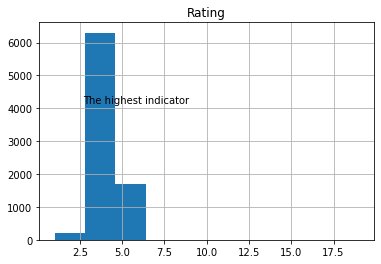

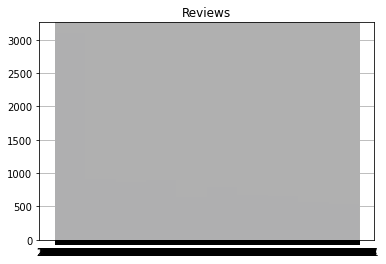

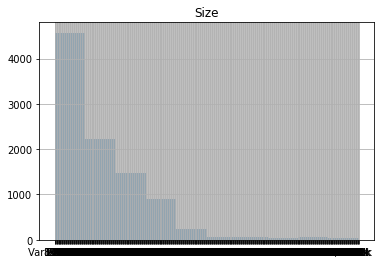

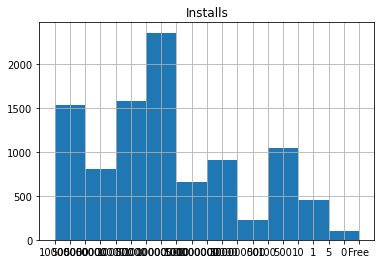

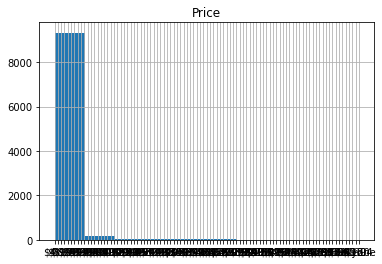

In [13]:
def print_histograms(dataset):
    plt.title("Rating")
    plt.hist(dataset["Rating"])
    plt.text(2.7, 4150, 'The highest indicator')
    plt.grid(True)
    plt.show()
    plt.title("Reviews")
    plt.hist(dataset["Reviews"])
    plt.grid(True)
    plt.show()
    plt.title("Size")
    plt.hist(dataset["Size"])
    plt.grid(True)
    plt.show()
    plt.title("Installs")
    plt.hist(dataset["Installs"])
    plt.grid(True)
    plt.show()
    plt.title("Price")
    plt.hist(dataset["Price"])
    plt.grid(True)
    plt.show()
print_histograms(data)

In [14]:
def compute_correlations_matrix(dataset):
    plt.figure(figsize=(10, 10))
    sns.heatmap(dataset.corr(), annot=True, cmap="YlOrRd", linewidths=0.1, annot_kws={"fontsize":10})
    plt.title("Correlation house prices - return rate")
    return plt.show()

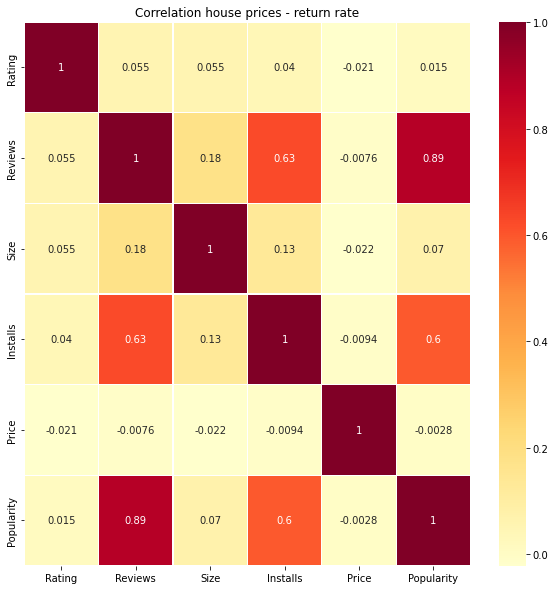

In [15]:
compute_correlations_matrix(df2)

its shape: (10358, 13)

its 10 first lines: 
                                                 App        Category  Rating  \
0     Photo Editor & Candy Camera & Grid & ScrapBook  ART_AND_DESIGN     4.1   
1                                Coloring book moana  ART_AND_DESIGN     3.9   
2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ART_AND_DESIGN     4.7   
3                              Sketch - Draw & Paint  ART_AND_DESIGN     4.5   
4              Pixel Draw - Number Art Coloring Book  ART_AND_DESIGN     4.3   
5                         Paper flowers instructions  ART_AND_DESIGN     4.4   
6            Smoke Effect Photo Maker - Smoke Editor  ART_AND_DESIGN     3.8   
7                                   Infinite Painter  ART_AND_DESIGN     4.1   
8                               Garden Coloring Book  ART_AND_DESIGN     4.4   
9                      Kids Paint Free - Drawing Fun  ART_AND_DESIGN     4.7   

  Reviews  Size     Installs  Type Price Content Rating  \
0     159   19M

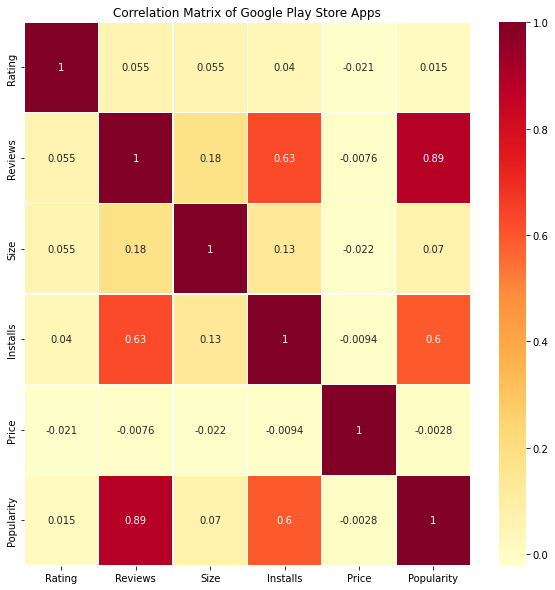

In [18]:
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

def load_dataset(data):
    df = pd.read_csv(data)
    df.drop_duplicates(inplace=True)
    return df

df = load_dataset('googleplaystore.csv')

def print_summarize_dataset(df):
    shapes = df.shape
    first_lines = df.head(10)
    statitsdic_df = df.describe()
    return f"its shape: {shapes}\n\nits 10 first lines: \n{first_lines}\n\n\nits statistical summary:\n{statitsdic_df}"

print(print_summarize_dataset(df))

def clean_dataset(dataset):
    # dropping the duplicated apps from the data.
    dataset.drop_duplicates(subset='App', inplace=True) 
    
    # cleaning Installs
    # removing free apps
    # converting installs column to integer type.
    dataset.Installs = dataset.Installs.str.replace('+', '').str.replace(',', '')
    dataset = dataset[dataset['Installs'] != 'Free']
    dataset.Installs = dataset.Installs.astype(int)
    
    # cleaning Size
    # replacing 'Varies with device' sizes to 'NaN'.
    # removing M from size items if the size was by megabytes.
    # converting sizes column to float type.
    dataset['Size'] = dataset['Size'].apply(lambda x: float(str(x).replace('k', '')) / 1000 if 'k' in str(x) else x) 
    dataset.Size = dataset.Size.str.replace('M', '').str.replace('Varies with device', 'NaN').str.replace(',', '').astype(float)

    # cleaning Price 
    # removing $ sign from price items.
    # converting prices column to float type.
    dataset.Price = dataset.Price.str.replace('$', '').astype('float')

    # cleaning Reviews
    # converting installs column to integer type.
    dataset['Reviews'] = dataset['Reviews'].astype('int')
    
    # normalizing
    dataset['Popularity'] = (dataset.Rating * 10**7 * dataset.Reviews * 10**2 * dataset.Installs) / 10**18 
    
    # dropping needless columns.
    dataset.drop(['Current Ver', 'Android Ver'], axis=1, inplace=True)
    return dataset

df2 = clean_dataset(df)
print('The original state of the data')
print(df.dtypes)

print('Clear data status')
print(df2.dtypes)

def compute_correlations_matrix(dataset):
    plt.figure(figsize=(10, 10))
    sns.heatmap(dataset.corr(), annot=True, cmap="YlOrRd", linewidths=0.1, annot_kws={"fontsize":10})
    plt.title("Correlation Matrix of Google Play Store Apps")
    plt.show()

compute_correlations_matrix(df2)


In [19]:
!gandalf



 ██████╗ ██╗    ██╗ █████╗ ███████╗ █████╗ ██████╗    ██╗ ██████╗ 
██╔═══██╗██║    ██║██╔══██╗██╔════╝██╔══██╗██╔══██╗   ██║██╔═══██╗
██║   ██║██║ █╗ ██║███████║███████╗███████║██████╔╝   ██║██║   ██║
██║▄▄ ██║██║███╗██║██╔══██║╚════██║██╔══██║██╔══██╗   ██║██║   ██║
╚██████╔╝╚███╔███╔╝██║  ██║███████║██║  ██║██║  ██║██╗██║╚██████╔╝
 ╚══▀▀═╝  ╚══╝╚══╝ ╚═╝  ╚═╝╚══════╝╚═╝  ╚═╝╚═╝  ╚═╝╚═╝╚═╝ ╚═════╝ 
																																 
Booting Gandalf v4.1.12-deab022 (production)
Loading parameters:  OK
User yunusov_f connection: OK


<MY_MOBAPP_STUDIO>
Directory . exists: OK
Pushing exercise: OK
Printing your report:

      REPORT        MY MOBAPP STUDIO 

 Status             SUCCESS          
 Execution Runtime  4.248337         
 Score              [=====-] 5/6     


Checks detail Report:

 TEST CLEAN DATASET  SUCCESS 



 TEST COMPUTE CORRELATIONS MATRIX  SUCCESS 



 TEST LOAD DATASET  SUCCESS 



 TEST PRINT HISTOGRAMS  SUCCESS 



 TEST PRINT SCATTER MATRIX                       

In [20]:
!git add .


In [21]:
!git commit -m"mobapppp"

[dev 59c59a0] mobapppp
 2 files changed, 456 insertions(+), 252 deletions(-)


In [22]:
!git push

Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 4 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 29.45 KiB | 4.91 MiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: . Processing 1 references
remote: Processed 1 references in total
To git.us.qwasar.io:my_mobapp_studio_140312_ove1wx/my_mobapp_studio.git
   4be2913..59c59a0  dev -> dev
